# Walmart Market Basket Analysis

### Attribute Information:

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.


* VisitNumber - an id corresponding to a single trip by a single customer


* Weekday - the weekday of the trip


* Upc - the UPC number of the product purchased


* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.


* DepartmentDescription - a high-level description of the item's department


* FinelineNumber - a more refined category for each of the products, created by Walmart


# Import Libraries 

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


# Load the Dataset 

In [2]:
walmart = pd.read_csv("train_walmart.csv")

In [3]:
# Display the data
walmart.head()

TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

In [4]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [5]:
walmart.describe()

TripType    VisitNumber           Upc      ScanCount  \
count  647054.000000  647054.000000  6.429250e+05  647054.000000   
mean       58.584511   96167.640078  3.060698e+10       1.108878   
std       157.635533   55545.485154  9.120134e+10       0.700776   
min         3.000000       5.000000  8.340000e+02     -12.000000   
25%        27.000000   49268.000000  3.400001e+09       1.000000   
50%        39.000000   97074.000000  7.050103e+09       1.000000   
75%        40.000000  144316.000000  3.006531e+10       1.000000   
max       999.000000  191347.000000  9.789707e+11      71.000000   

       FinelineNumber  
count   642925.000000  
mean      3726.884567  
std       2780.966158  
min          0.000000  
25%       1404.000000  
50%       3352.000000  
75%       5501.000000  
max       9998.000000

In [6]:
#Shape of the data
walmart.shape

(647054, 7)

In [7]:
#Check the datatypes
walmart.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

## Handling Missing values


In [8]:
#Check for missing values
print('Number of missing values across columns: \n', walmart.isnull().sum())

Number of missing values across columns: 
 TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64


In [9]:
#display how many nulls are in each column
import plotly.express as px

px.bar(walmart.isnull().sum()
       ,title='Null values per Column'
       ,color=walmart.isnull().sum().index)

### Replace Null values with the most frequent  values

In [10]:
#Find the most frequent value in the refer column
walmart.FinelineNumber.value_counts(ascending=False).to_frame()

FinelineNumber
5501.0            8244
1508.0            5121
135.0             4538
808.0             4401
0.0               3837
...                ...
2311.0               1
524.0                1
7130.0               1
2847.0               1
7313.0               1

[5195 rows x 1 columns]

In [11]:
#Replace FinelineNumber feature with the mean value
walmart['FinelineNumber'].fillna(walmart['FinelineNumber'].mean(), inplace = True)

In [12]:
walmart.DepartmentDescription.value_counts(ascending=False).to_frame()

DepartmentDescription
GROCERY DRY GOODS                       70402
DSD GROCERY                             68332
PRODUCE                                 51115
DAIRY                                   43820
PERSONAL CARE                           41969
...                                       ...
LARGE HOUSEHOLD GOODS                      77
CONCEPT STORES                             35
SEASONAL                                   29
OTHER DEPARTMENTS                          29
HEALTH AND BEAUTY AIDS                      2

[68 rows x 1 columns]

In [13]:
# Department Description fill with value NONE
walmart['DepartmentDescription'].fillna( 'NONE', inplace = True)

In [14]:
walmart.Upc.value_counts().to_frame()

Upc
4.011000e+03  7657
6.053886e+10  2501
7.874235e+09  2067
7.874235e+09  1883
4.046000e+03  1652
...            ...
8.437471e+10     1
7.644011e+09     1
1.119231e+09     1
7.670528e+10     1
8.669413e+09     1

[97714 rows x 1 columns]

In [15]:
walmart.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [16]:
def float_to_str(obj):
    """
    Convert Upc code from float to string.
    Parameters: "Upc" column of DataFrame
    Return:string converted Upc removing dot
    """
    while obj != 'np.nan':
        obj = str(obj).split('.')[0]
        if len(obj) == 10:
            obj = obj + '0'
        elif len(obj) == 4:
            obj = obj + '0000000' 
        return obj

In [17]:
walmart['new_Upc'] = walmart['Upc'].apply(float_to_str)
walmart.drop(['Upc'], axis=1)

TripType  VisitNumber Weekday  ScanCount  DepartmentDescription  \
0            999            5  Friday         -1     FINANCIAL SERVICES   
1             30            7  Friday          1                  SHOES   
2             30            7  Friday          1          PERSONAL CARE   
3             26            8  Friday          2  PAINT AND ACCESSORIES   
4             26            8  Friday          2  PAINT AND ACCESSORIES   
...          ...          ...     ...        ...                    ...   
647049        39       191346  Sunday          1           PHARMACY OTC   
647050        39       191346  Sunday          1           FROZEN FOODS   
647051        39       191346  Sunday          1                PRODUCE   
647052         8       191347  Sunday          1                  DAIRY   
647053         8       191347  Sunday          1      GROCERY DRY GOODS   

        FinelineNumber      new_Upc  
0               1000.0  68113152929  
1               8931.0  60538815980  
2               4504.0  74108110990  
3               3565.0  22384035100  
4               1017.0  20066137440  
...                ...          ...  
647049          1118.0  32390001778  
647050          1752.0  78742053360  
647051          4170.0  40720000000  
647052          1512.0  41900076640  
647053          3600.0  38000596550  

[647054 rows x 7 columns]

In [18]:
walmart.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription       0
FinelineNumber              0
new_Upc                     0
dtype: int64

## Data Exploration

In [19]:
walmart['Weekday'].unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

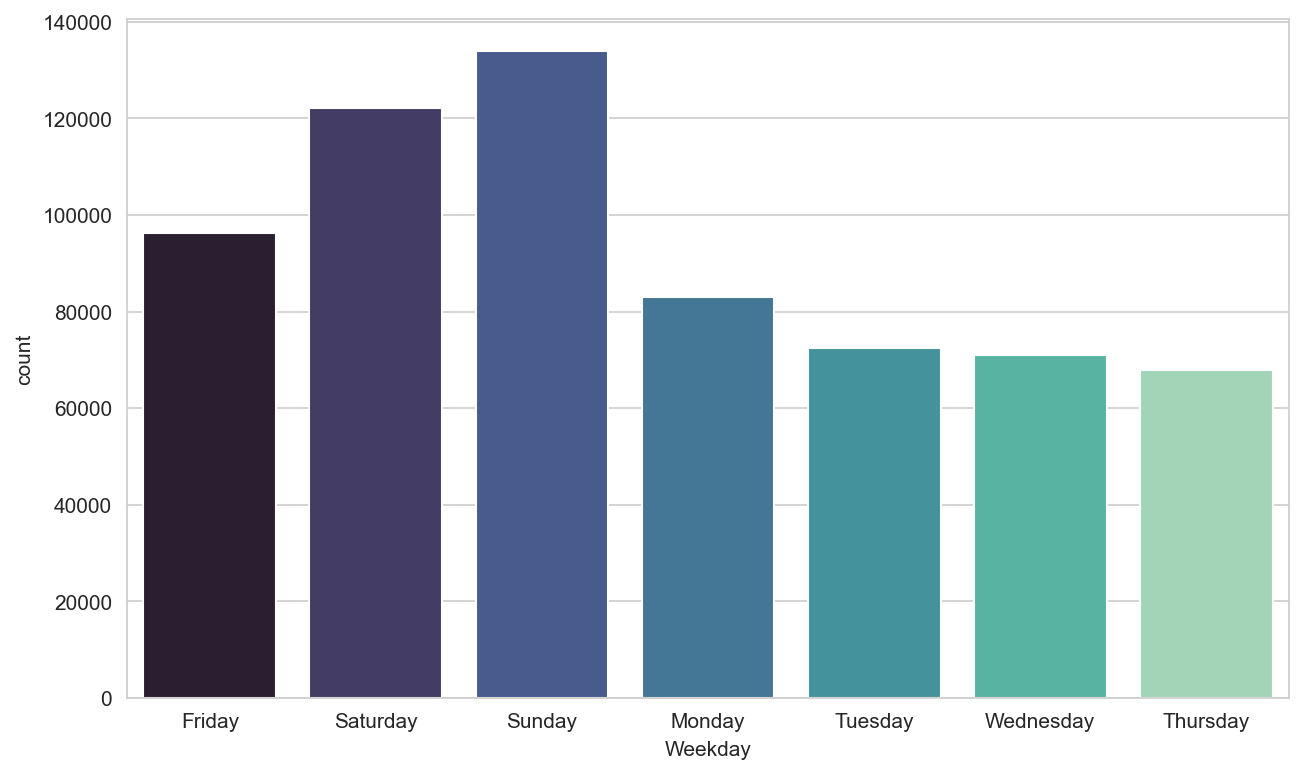

In [20]:
plt.figure(figsize=(10,6),dpi=150)
sns.set_style('whitegrid')
sns.countplot(data=walmart, x = 'Weekday', palette='mako');

In [21]:
walmart['TripType'].unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12],
      dtype=int64)

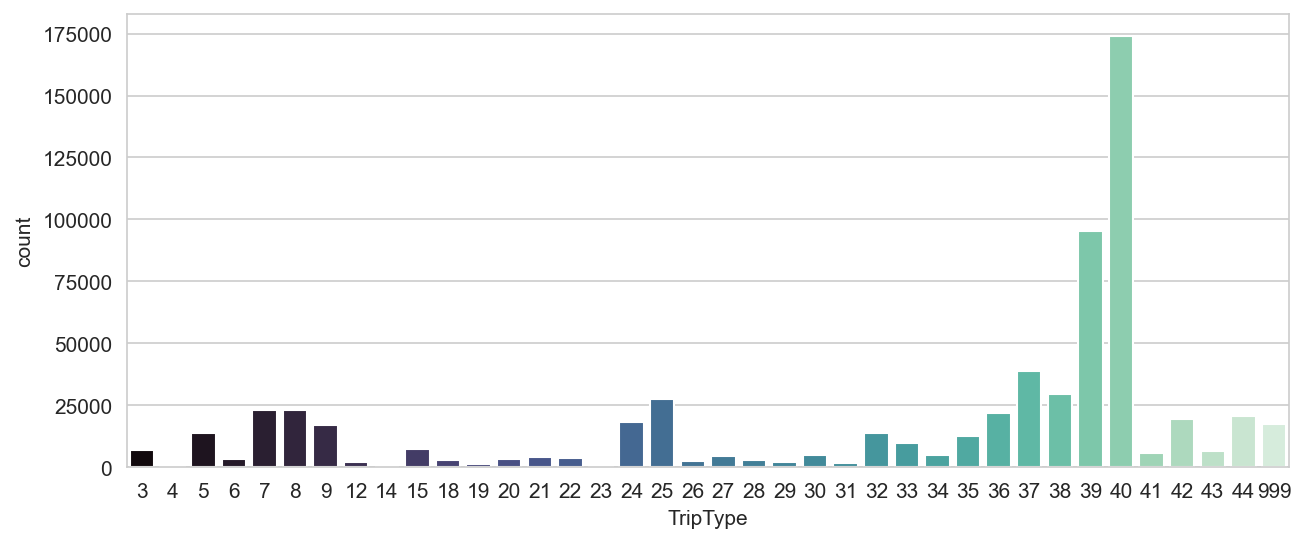

In [22]:
plt.figure(figsize=(10,4),dpi=150)
sns.set_style('whitegrid')
sns.countplot(data=walmart, x = 'TripType', palette='mako');

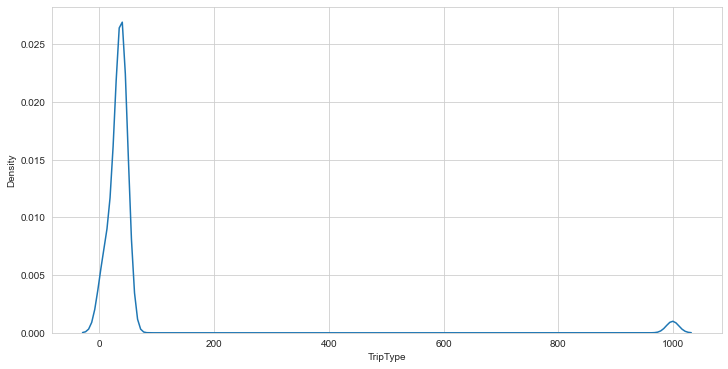

In [23]:
plt.figure(figsize=(12,6))
sns.distplot(walmart.TripType,hist=False);

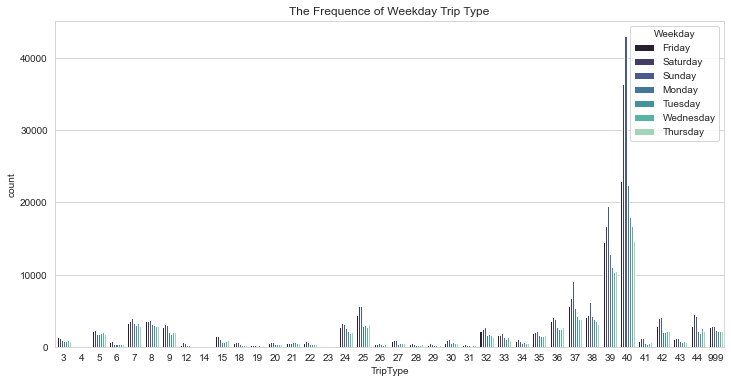

In [24]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
ax1 = sns.countplot(x = 'TripType', hue = 'Weekday', data = walmart, palette = 'mako')
plt.title('The Frequence of Weekday Trip Type');

In [25]:
walmart['ScanCount'].unique()

array([ -1,   1,   2,   3,   5,   6,   4,  14,  -2,   9,   7,  10,   8,
        -3,  -5,  11,  16,  -4,  13,  15,  30,  -6,  12,  20, -12,  19,
        46,  23,  -7,  22,  25,  24,  31,  -9,  51,  17,  18,  71, -10],
      dtype=int64)

### Investigate possible ScanCount outiliers

* -12 as min value and 71 as max value seems to be out of curve.
* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.

In [26]:
walmart['ScanCount'].describe().to_frame()

ScanCount
count  647054.000000
mean        1.108878
std         0.700776
min       -12.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        71.000000

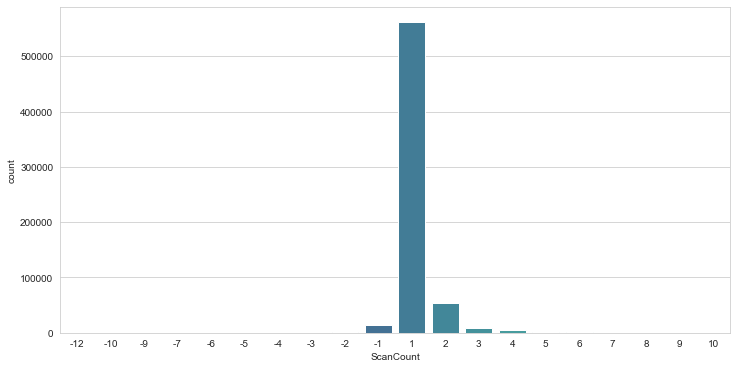

In [27]:
plt.figure(figsize=(12,6))
sns.countplot(walmart[walmart.ScanCount<=10].ScanCount,  palette='mako');

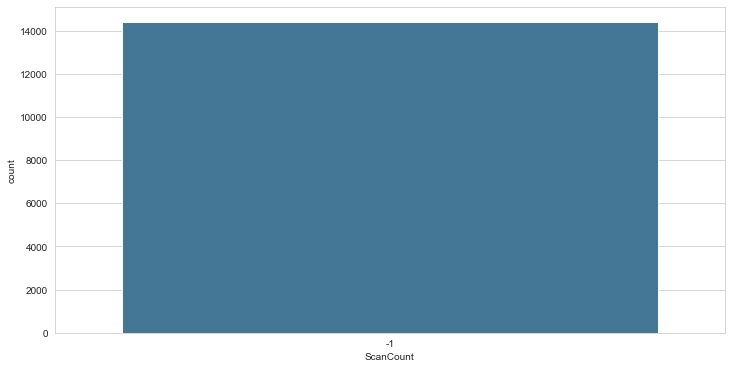

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(walmart[walmart.ScanCount == -1].ScanCount,  palette='mako');

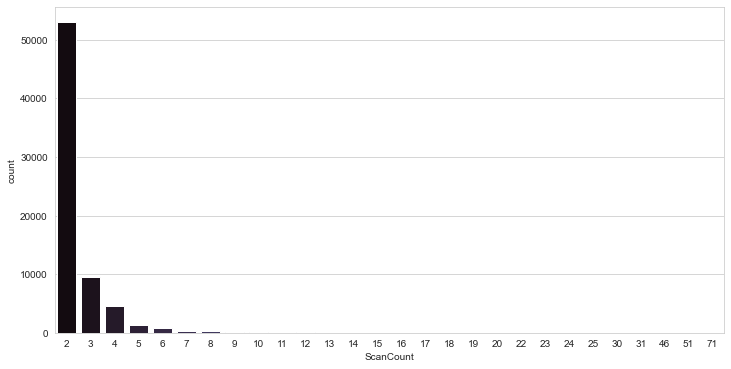

In [29]:
plt.figure(figsize=(12,6))
sns.countplot(walmart[walmart.ScanCount>1].ScanCount,  palette='mako');

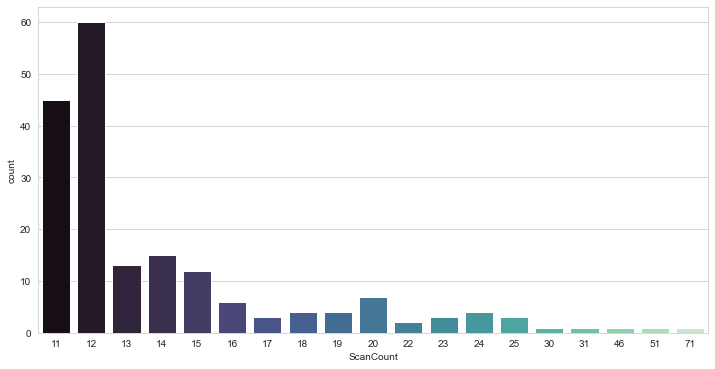

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(walmart[walmart.ScanCount>10].ScanCount,  palette='mako');

_We can conclude that there are visits for ScanCount of 1 the most(over 500k). and as number of ScanCount increases, the count of data points decreases. Also, there was not many data points for returned products, since negative ScanCounts are most concentrated in the -1 (14k)._

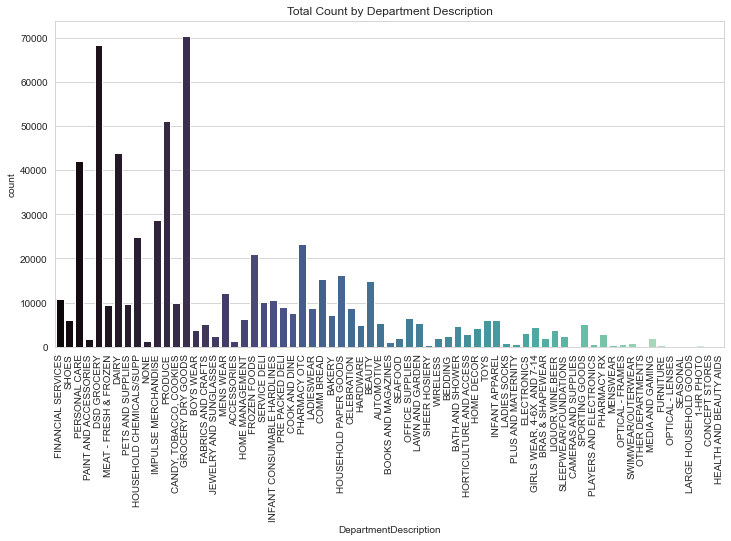

In [31]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.countplot(x='DepartmentDescription',data=walmart, palette= 'mako')
plt.title('Total Count by Department Description')
plt.xticks(rotation=90)
plt.show();

In [32]:
scan = pd.DataFrame(walmart.groupby('DepartmentDescription')['ScanCount'].count().sort_values(ascending=False))
scan.head()

ScanCount
DepartmentDescription           
GROCERY DRY GOODS          70402
DSD GROCERY                68332
PRODUCE                    51115
DAIRY                      43820
PERSONAL CARE              41969

In [33]:
walmart['DepartmentDescription'].unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', 'NONE',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEA

**The item that has been purchase and return in the same visit should be cut**

In [34]:
walmart.loc[walmart.duplicated(subset=['TripType', 'VisitNumber', 'Weekday', 'new_Upc', 'DepartmentDescription', 
                                       'FinelineNumber'], keep=False)]

TripType  VisitNumber Weekday           Upc  ScanCount  \
9             26            8  Friday  2.238400e+09         -1   
11            26            8  Friday  8.867930e+10          2   
14            26            8  Friday  8.867930e+10         -1   
15            26            8  Friday  2.238400e+09          2   
55            42           19  Friday  7.675336e+09          1   
...          ...          ...     ...           ...        ...   
646845        40       191298  Sunday  6.811310e+10          1   
646984        38       191337  Sunday  2.259120e+10          1   
646985        38       191337  Sunday  2.259120e+10         -1   
647004        38       191337  Sunday  2.261680e+10         -1   
647005        38       191337  Sunday  2.261680e+10          1   

        DepartmentDescription  FinelineNumber      new_Upc  
9       PAINT AND ACCESSORIES          3565.0  22384002000  
11      PAINT AND ACCESSORIES          3504.0  88679300501  
14      PAINT AND ACCESSORIES          3504.0  88679300501  
15      PAINT AND ACCESSORIES          3565.0  22384002000  
55        IMPULSE MERCHANDISE          8904.0  76753357440  
...                       ...             ...          ...  
646845                 BEAUTY          4541.0  68113103499  
646984  MEAT - FRESH & FROZEN          1301.0  22591200000  
646985  MEAT - FRESH & FROZEN          1301.0  22591200000  
647004  MEAT - FRESH & FROZEN          6405.0  22616800000  
647005  MEAT - FRESH & FROZEN          6405.0  22616800000  

[29897 rows x 8 columns]

In [35]:
walmart = walmart.groupby(['new_Upc', 'TripType', 'VisitNumber', 'Weekday',
            'DepartmentDescription', 'FinelineNumber'])['ScanCount'].sum().reset_index()
walmart.head(3)

new_Upc  TripType  VisitNumber    Weekday    DepartmentDescription  \
0  10086671060        23       104891     Sunday  PLAYERS AND ELECTRONICS   
1  10086671100        23       138942   Saturday  PLAYERS AND ELECTRONICS   
2  10164440860         5        79783  Wednesday         OPTICAL - FRAMES   

   FinelineNumber  ScanCount  
0          1134.0          1  
1          1134.0          1  
2          5009.0          1

In [36]:
# Get top ranked ranked customers based on the total amount
VisitNumber_amounts = walmart.groupby('VisitNumber')['ScanCount'].agg(np.sum).sort_values(ascending=False)
VisitNumber_amounts.to_frame('total_scan')

total_scan
VisitNumber            
72439               311
88011               183
9181                137
65792               133
178154              133
...                 ...
133103              -23
61053               -26
50671               -26
131193              -37
27471               -52

[95674 rows x 1 columns]

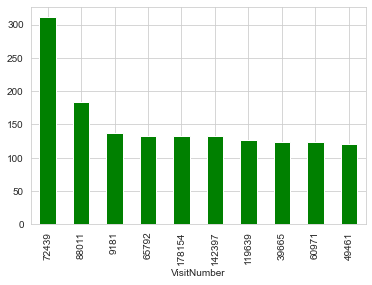

In [37]:
VisitNumber_amounts.head(10).plot.bar(color='green');

#### Create new column called: num_of_products_by_VisitNumber

In [38]:
# Identify in each VisitNumber how many products were purchased based on Upc number of product purchased
products_by_visit=walmart.groupby(['VisitNumber'])['new_Upc'].count()
products_by_visit_dict=dict(products_by_visit)

In [39]:
walmart['num_of_products_by_VisitNumber']=walmart['VisitNumber'].apply(lambda x:products_by_visit_dict.get(x,0))

In [40]:
walmart.head()

new_Upc  TripType  VisitNumber    Weekday    DepartmentDescription  \
0  10086671060        23       104891     Sunday  PLAYERS AND ELECTRONICS   
1  10086671100        23       138942   Saturday  PLAYERS AND ELECTRONICS   
2  10164440860         5        79783  Wednesday         OPTICAL - FRAMES   
3  10164440860         5       137542   Saturday         OPTICAL - FRAMES   
4  10164440860         5       174628     Friday         OPTICAL - FRAMES   

   FinelineNumber  ScanCount  num_of_products_by_VisitNumber  
0          1134.0          1                               1  
1          1134.0          1                               1  
2          5009.0          1                               2  
3          5009.0          1                               2  
4          5009.0          1                               2

In [41]:
walmart['num_of_products_by_VisitNumber'].unique()

array([  1,   2,   3,   5,   6,   7,   8,  24,  29,  33,  20,  26,  10,
         4,  13,  28,  11,   9,  44,  14,  41,  16,  19,  27,  31,  47,
        12,  18,  32,  39,  46,  17,  23,  21,  62,  45,  36,  59,  15,
        30,  42,  71,  43,  22,  55,  63,  25,  49,  34,  35, 113,  54,
        56,  52,  58,  51,  40,  69,  37,  61, 110,  38,  53,  65,  60,
        50,  96,  48,  67, 195,  73,  83, 150,  70,  64,  57,  72,  68,
        89,  79,  88,  77,  80,  66,  84,  78,  75,  74,  82, 112,  93,
        91,  86,  76,  94, 104,  92,  81,  95], dtype=int64)

In [42]:
walmart.num_of_products_by_VisitNumber.nunique()

99

In [43]:
walmart['TripType'].unique()

array([ 23,   5,  36,  39,  25,  40,   3,  44,  43,  42,  27,   8,  21,
        38,  30,  24,   7,  12,  18,  37,  41,  20, 999,  31,   9,  26,
        35,  15,  19,  34,  28,  32,  33,  22,   6,  29,   4,  14],
      dtype=int64)

In [44]:
walmart.TripType.nunique()

38

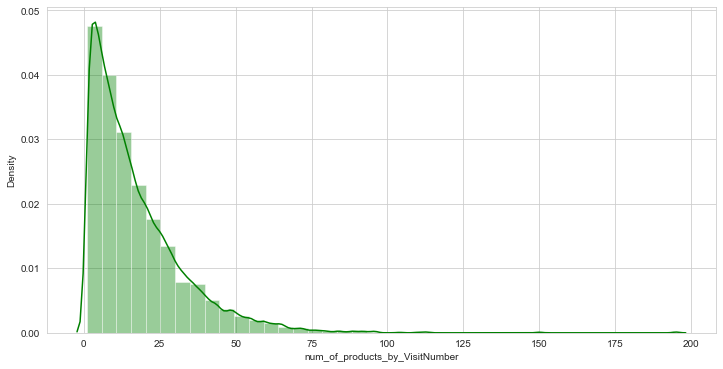

In [45]:
plt.figure(figsize=(12,6))
sns.distplot(walmart.num_of_products_by_VisitNumber,bins=40, color='green');

__The distribution of number of products purchased by each VisitNumber is right skewed. So, there are more probability of buying less number of products__

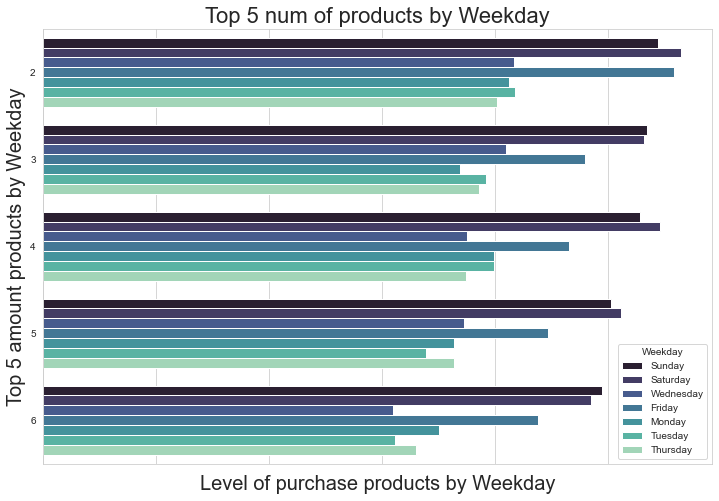

In [46]:
#Setting plot style
plt.figure(figsize = (12, 8))

#Top 5 num of products by Weekday
ax=sns.countplot(y='num_of_products_by_VisitNumber', hue='Weekday', data=walmart, palette='mako',
              order=walmart.num_of_products_by_VisitNumber.value_counts().iloc[:5].index)

ax.set_xticklabels(ax.get_xticklabels(),fontsize=11,rotation=40, ha='right')
ax.set_title('Top 5 num of products by Weekday',fontsize= 22)
ax.set_xlabel('Level of purchase products by Weekday',fontsize = 20) 
ax.set_ylabel('Top 5 amount products by Weekday', fontsize = 20)
plt.show();

### Top 10 Department Description

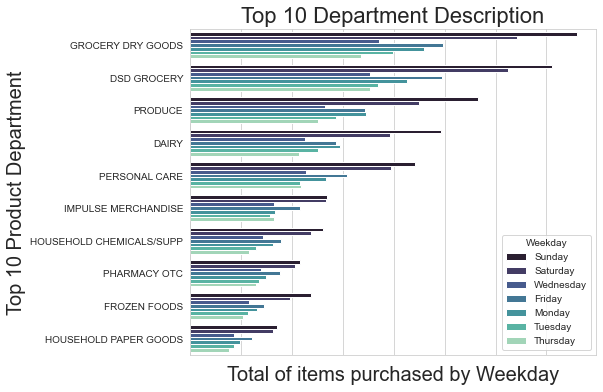

In [47]:
#Setting plot style
plt.figure(figsize = (16, 6))

#Top 10 Department Description
plt.subplot(1,2,1)
ax=sns.countplot(y='DepartmentDescription', hue='Weekday', data=walmart, palette='mako',
              order=walmart.DepartmentDescription.value_counts().iloc[:10].index)

ax.set_xticklabels(ax.get_xticklabels(),fontsize=11,rotation=40, ha='right')
ax.set_title('Top 10 Department Description',fontsize= 22)
ax.set_xlabel('Total of items purchased by Weekday',fontsize = 20) 
ax.set_ylabel('Top 10 Product Department', fontsize = 20)
plt.show();

### Top UPC - number of the product purchased

In [48]:
import altair as alt
#Getting the top customers based on quantity purchased
top_upc = walmart[['new_Upc', 'ScanCount','Weekday']].sort_values(by = 'ScanCount',ascending = False).head(100)

#Converting the datatype of upc and weekday
top_upc.new_Upc = top_upc.new_Upc.astype('category') 
top_upc.Weekday = top_upc.Weekday.astype('category') 

#Plotting
alt.Chart(top_upc).mark_bar(color='darkgreen').encode(
    x='ScanCount',
    y=alt.Y('new_Upc', sort='-x'),
    color='Weekday',
    tooltip=['new_Upc','ScanCount']
).properties(height=900,width=700,title='Top UPC')

alt.Chart(...)

In [49]:
top_total_product = walmart[['num_of_products_by_VisitNumber', 'ScanCount','Weekday']].sort_values(by = 'ScanCount',ascending = False).head(300)

#Converting the datatype of num_of_products_by_VisitNumber and weekday
top_total_product.num_of_products_by_VisitNumber = top_total_product.num_of_products_by_VisitNumber.astype('category') 
top_total_product.Weekday = top_total_product.Weekday.astype('category') 

#Plotting
alt.Chart(top_total_product).mark_bar(color='darkgreen').encode(
    x='ScanCount',
    y=alt.Y('num_of_products_by_VisitNumber', sort='-x'),
    color='Weekday',
    tooltip=['num_of_products_by_VisitNumber','ScanCount']
).properties(height=900,width=700,title='Top total product scan by Weekday')

alt.Chart(...)

## Customer Segmentation

The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.
A good segmentation process will encompass indicators such as customer relationship time, based on the date of your first purchase of the client, group or category of product to be obtained based on the 'VisitNumber' (SKUs), all contributes to an optimal segments that provide valuable insights.

__Association rule-mining__ is based on the concept that customer purchase behavior has a pattern which can be exploited for selling more items to the customer in the future. Here we are using a cross selling technique by apply the concept of market basket analysis to our walmart transactions dataset.


In [50]:
#Make a copy of the Dataset before set the features to modeling
walmart_df = walmart.copy()

In [51]:
walmart_df.drop(columns=['TripType','new_Upc','Weekday','ScanCount','FinelineNumber','num_of_products_by_VisitNumber'], 
                axis=1, inplace=True)
walmart_df.head()

VisitNumber    DepartmentDescription
0       104891  PLAYERS AND ELECTRONICS
1       138942  PLAYERS AND ELECTRONICS
2        79783         OPTICAL - FRAMES
3       137542         OPTICAL - FRAMES
4       174628         OPTICAL - FRAMES

### First alternative

In [52]:
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter

In [53]:
# get all the transcactions as a list
transcactions = list(walmart_df['DepartmentDescription'])
# instantiate transcation encoder
encoder = TransactionEncoder().fit(transcactions)
onehot = encoder.transform(transcactions)
# convert one-hot encode data to DataFrame
onehot = pd.DataFrame(onehot, columns=encoder.columns_)
# compute frequent items using the Apriori algorithm - Get up to two items
frequent_itemsets = apriori(onehot, min_support = 0.07,max_len=2, use_colnames=True)
# compute all association rules for frequent_itemsets
#H ere we are setting based on lift and has minimum lift as 1
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

In [54]:

rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>0.5].sort_values('lift', ascending=False).head()

antecedents consequents  antecedent support  consequent support   support  \
134         (H)         (M)            0.227383            0.228893  0.169441   
135         (M)         (H)            0.228893            0.227383  0.169441   
54          (B)         (T)            0.137501            0.214068  0.082739   
55          (T)         (B)            0.214068            0.137501  0.082739   
115         (N)         (F)            0.359651            0.116308  0.102411   

     confidence      lift  leverage  conviction  lhs items  
134    0.745181  3.255589  0.117395    3.026093          1  
135    0.740265  3.255589  0.117395    2.974641          1  
54     0.601733  2.810944  0.053304    1.973379          1  
55     0.386508  2.810944  0.053304    1.405884          1  
115    0.284752  2.448259  0.060581    1.235504          1

In [55]:
# as based business use case we can sort based on confidance and lift.
rules[(rules['lift'] >= 1.5) & (rules['confidence'] >= 0.7)]

antecedents consequents  antecedent support  consequent support   support  \
28          (B)         (A)            0.137501            0.592945  0.128142   
32          (H)         (A)            0.227383            0.592945  0.210461   
39          (M)         (A)            0.228893            0.592945  0.222667   
45          (T)         (A)            0.214068            0.592945  0.190848   
48          (W)         (A)            0.088965            0.592945  0.080163   
114         (F)         (N)            0.116308            0.359651  0.102411   
129         (G)         (Y)            0.284971            0.393979  0.219204   
134         (H)         (M)            0.227383            0.228893  0.169441   
135         (M)         (H)            0.228893            0.227383  0.169441   
149         (L)         (I)            0.343705            0.374597  0.240598   
194         (U)         (P)            0.281873            0.362267  0.217634   

     confidence      lift  leverage  conviction  lhs items  
28     0.931932  1.571701  0.046611    5.980154          1  
32     0.925578  1.560985  0.075635    5.469559          1  
39     0.972800  1.640625  0.086946   14.965331          1  
45     0.891532  1.503567  0.063918    3.752782          1  
48     0.901065  1.519643  0.027412    4.114362          1  
114    0.880520  2.448259  0.060581    5.359452          1  
129    0.769214  1.952422  0.106931    2.625896          1  
134    0.745181  3.255589  0.117395    3.026093          1  
135    0.740265  3.255589  0.117395    2.974641          1  
149    0.700014  1.868714  0.111848    2.084774          1  
194    0.772100  2.131302  0.115521    2.798304          1

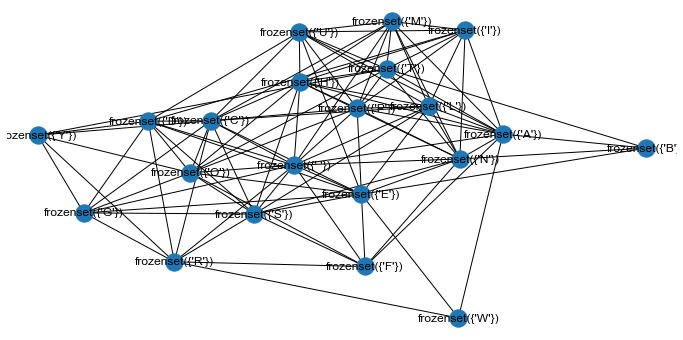

In [56]:
#plotting output in a graph plot.
import networkx as nx

fig, ax=plt.subplots(figsize=(12,6))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

### Second alternative

In [57]:
onehot = walmart_df.pivot_table(index='VisitNumber', columns='DepartmentDescription', aggfunc=len, fill_value=0)
onehot = onehot>0

In [58]:
# compute frequent items using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.07, max_len=2, use_colnames=False)
# compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets)
rules.head()

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [59]:
rules[rules.antecedents.apply(str).str.contains('LARGE HOUSEHOLD GOODS')].sort_values('lift', ascending=False)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [60]:
rules.sort_values('confidence', ascending=False).head(5)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

----------------------------------------
------------------------------------

#### Third alternative

 # Apriori Association Rules Model

In [61]:
walmart.head(2)

new_Upc  TripType  VisitNumber   Weekday    DepartmentDescription  \
0  10086671060        23       104891    Sunday  PLAYERS AND ELECTRONICS   
1  10086671100        23       138942  Saturday  PLAYERS AND ELECTRONICS   

   FinelineNumber  ScanCount  num_of_products_by_VisitNumber  
0          1134.0          1                               1  
1          1134.0          1                               1

In [62]:
fig = px.treemap(walmart, path=['DepartmentDescription'], values='ScanCount')
fig.show()

In [63]:
temp = walmart.copy()

In [64]:
#Creating sparse matrix 
basket = (temp.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount']
          .sum().unstack().reset_index().fillna(0)
          .set_index('VisitNumber'))

#Encoding the quantity purchased
def encode(x):
    '''Encoding the scancount with 0s and 1s
    0:when qty is less than or equal to 0
    1:when qty is greater than or equal to 1'''
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
#Appying on our data
basket_sets = basket.applymap(encode)
basket_sets

DepartmentDescription  1-HR PHOTO  ACCESSORIES  AUTOMOTIVE  BAKERY  \
VisitNumber                                                          
5                               0            0           0       0   
7                               0            0           0       0   
8                               0            0           0       0   
9                               0            0           0       0   
10                              0            0           0       0   
...                           ...          ...         ...     ...   
191343                          0            0           0       0   
191344                          0            0           0       0   
191345                          0            0           0       0   
191346                          0            0           0       0   
191347                          0            0           0       0   

DepartmentDescription  BATH AND SHOWER  BEAUTY  BEDDING  BOOKS AND MAGAZINES  \
VisitNumber                                                                    
5                                    0       0        0                    0   
7                                    0       0        0                    0   
8                                    0       0        0                    0   
9                                    0       0        0                    0   
10                                   0       0        0                    0   
...                                ...     ...      ...                  ...   
191343                               0       0        0                    0   
191344                               0       1        0                    0   
191345                               0       1        0                    0   
191346                               0       0        0                    0   
191347                               0       0        0                    0   

DepartmentDescription  BOYS WEAR  BRAS & SHAPEWEAR  ...  SEAFOOD  SEASONAL  \
VisitNumber                                         ...                      
5                              0                 0  ...        0         0   
7                              0                 0  ...        0         0   
8                              0                 0  ...        0         0   
9                              0                 0  ...        0         0   
10                             0                 0  ...        0         0   
...                          ...               ...  ...      ...       ...   
191343                         0                 0  ...        0         0   
191344                         0                 0  ...        0         0   
191345                         0                 0  ...        0         0   
191346                         0                 0  ...        0         0   
191347                         0                 0  ...        0         0   

DepartmentDescription  SERVICE DELI  SHEER HOSIERY  SHOES  \
VisitNumber                                                 
5                                 0              0      0   
7                                 0              0      1   
8                                 0              0      0   
9                                 0              0      0   
10                                0              0      0   
...                             ...            ...    ...   
191343                            0              0      0   
191344                            0              0      0   
191345                            0              0      0   
191346                            0              0      0   
191347                            0              0      0   

DepartmentDescription  SLEEPWEAR/FOUNDATIONS  SPORTING GOODS  \
VisitNumber                                                    
5                                          0               0   
7                                          0   

### Applying Apriori Algorithm

In [65]:
#Apply 5% of confidence
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True, verbose=1)
frequent_itemsets.head()

Processing 4 combinations | Sampling itemset size 4


support              itemsets
0  0.084704              (BEAUTY)
1  0.103999          (COMM BREAD)
2  0.186153               (DAIRY)
3  0.306980         (DSD GROCERY)
4  0.074252  (FINANCIAL SERVICES)

In [66]:
frequent_itemsets ['length'] = frequent_itemsets ['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head(5)

support              itemsets  length
0  0.084704              (BEAUTY)       1
1  0.103999          (COMM BREAD)       1
2  0.186153               (DAIRY)       1
3  0.306980         (DSD GROCERY)       1
4  0.074252  (FINANCIAL SERVICES)       1

In [67]:
frequent_itemsets.tail(5)

support                                   itemsets  length
20  0.075935               (DSD GROCERY, PERSONAL CARE)       2
21  0.108023                     (DSD GROCERY, PRODUCE)       2
22  0.105713               (GROCERY DRY GOODS, PRODUCE)       2
23  0.081506    (GROCERY DRY GOODS, DSD GROCERY, DAIRY)       3
24  0.073447  (GROCERY DRY GOODS, DSD GROCERY, PRODUCE)       3

In [68]:
#Associaton rules-using confidence
rules_conf = association_rules(frequent_itemsets, metric='lift', min_threshold=0.7)  #metric can be changed for 'confidence'
rules_conf.head()

antecedents          consequents  antecedent support  \
0         (COMM BREAD)  (GROCERY DRY GOODS)            0.103999   
1  (GROCERY DRY GOODS)         (COMM BREAD)            0.222673   
2        (DSD GROCERY)              (DAIRY)            0.306980   
3              (DAIRY)        (DSD GROCERY)            0.186153   
4  (GROCERY DRY GOODS)              (DAIRY)            0.222673   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.222673  0.071880    0.691156  3.103907  0.048722    2.516891  
1            0.103999  0.071880    0.322803  3.103907  0.048722    1.323103  
2            0.186153  0.116197    0.378515  2.033357  0.059051    1.309521  
3            0.306980  0.116197    0.624200  2.033357  0.059051    1.844119  
4            0.186153  0.115820    0.520137  2.794138  0.074369    1.695999

In [69]:
#Associaton rules-using confidence
rules_conf = association_rules(frequent_itemsets, metric='lift', min_threshold=0.7) 
rules_conf.head()

antecedents          consequents  antecedent support  \
0         (COMM BREAD)  (GROCERY DRY GOODS)            0.103999   
1  (GROCERY DRY GOODS)         (COMM BREAD)            0.222673   
2        (DSD GROCERY)              (DAIRY)            0.306980   
3              (DAIRY)        (DSD GROCERY)            0.186153   
4  (GROCERY DRY GOODS)              (DAIRY)            0.222673   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.222673  0.071880    0.691156  3.103907  0.048722    2.516891  
1            0.103999  0.071880    0.322803  3.103907  0.048722    1.323103  
2            0.186153  0.116197    0.378515  2.033357  0.059051    1.309521  
3            0.306980  0.116197    0.624200  2.033357  0.059051    1.844119  
4            0.186153  0.115820    0.520137  2.794138  0.074369    1.695999

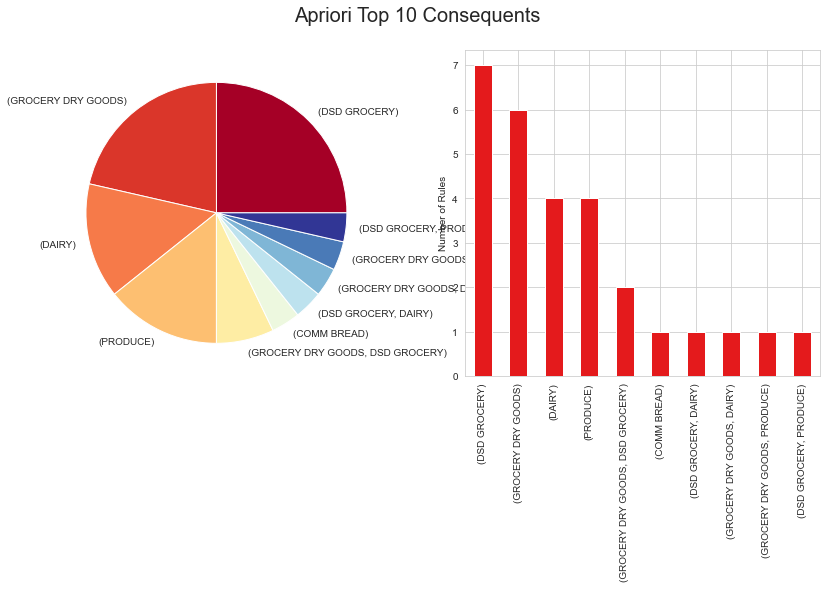

In [90]:
plt.rcParams['figure.figsize'] = (14,6)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Apriori Top 10 Consequents', fontsize=20)
rules_conf['consequents'].value_counts()[:10].plot(kind='pie', colormap = 'RdYlBu' , ax=ax1, ylabel='')
rules_conf['consequents'].value_counts()[:10].plot(kind='bar', colormap = 'Set1' , ax=ax2, ylabel='Number of Rules');

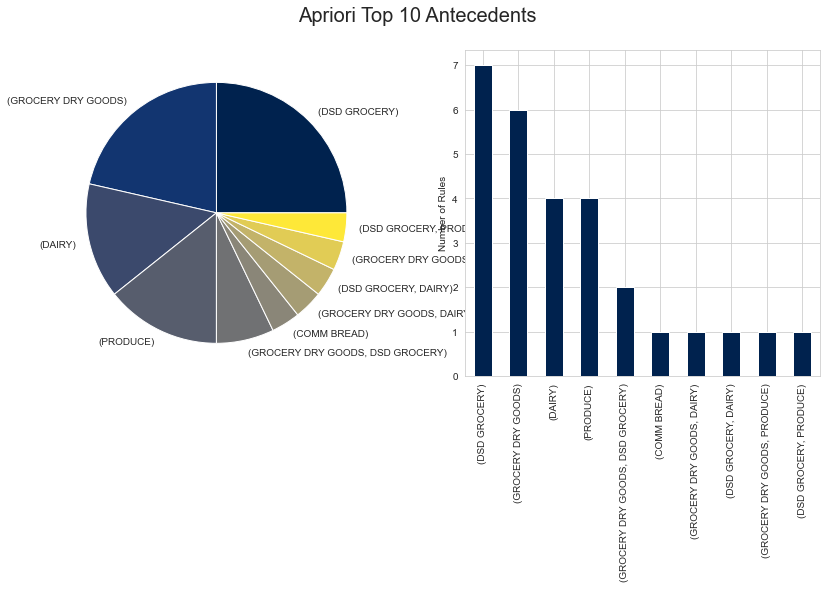

In [71]:
plt.rcParams['figure.figsize'] = (14,6)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Apriori Top 10 Antecedents', fontsize=20)
rules_conf['antecedents'].value_counts()[:10].plot(kind='pie', colormap = 'cividis' , ax=ax1, ylabel='');
rules_conf['antecedents'].value_counts()[:10].plot(kind='bar', colormap ='cividis' , ax=ax2, ylabel='Number of Rules');

### Visualizing the results
The results in tabular form will not convey much insights into our algorithm so let's visualize the rules andd found the relationship between the metrics.

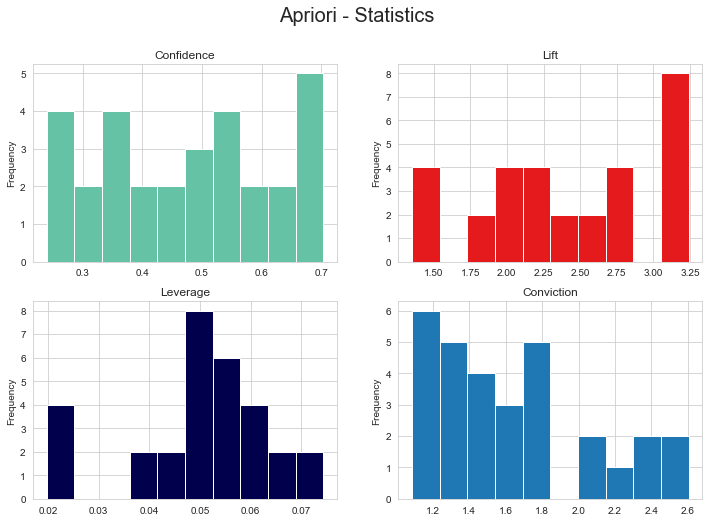

In [88]:
plt.rcParams['figure.figsize'] = (12,8)
fig, axs = plt.subplots(2,2)
fig.suptitle('Apriori - Statistics', fontsize=20)
rules_conf.confidence.plot(kind='hist', ax=axs[0,0], title = 'Confidence', colormap = 'Set2')
rules_conf.lift.plot(kind='hist', ax=axs[0,1], title = 'Lift', colormap = 'Set1')
rules_conf.leverage.plot(kind='hist', ax=axs[1,0], title = 'Leverage', colormap = 'seismic')
rules_conf.conviction.plot(kind='hist', ax=axs[1,1], title = 'Conviction', colormap = 'tab20');

In [73]:
fig=px.scatter(rules_conf['support'], rules_conf['confidence'])
fig.update_layout(
    xaxis_title='support',
    yaxis_title='confidence',
    font_family='Arial',
    font_color='green',
    title=('Support vs Confidence')
    
)

fig.show();

In [74]:
fig=px.scatter(rules_conf['support'],rules_conf['lift'])
fig.update_layout(
    xaxis_title='support',
    yaxis_title='lift',
    font_family='Arial',
    font_color='green',
    title=('Support vs Lift')
    
)

fig.show();

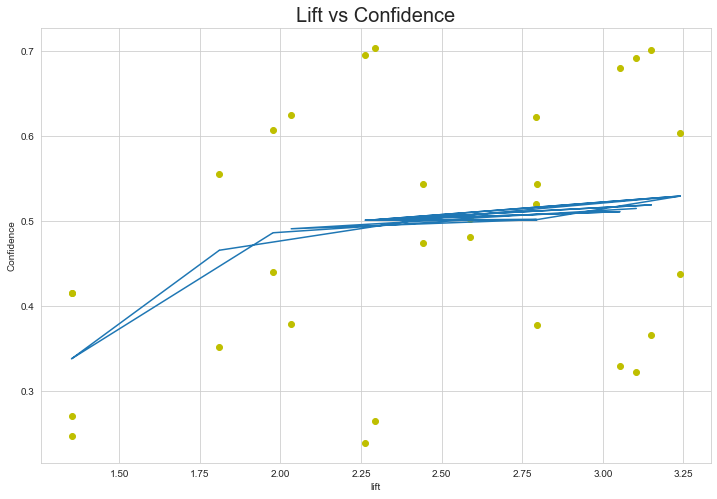

In [75]:
fit = np.polyfit(rules_conf['lift'], rules_conf['confidence'], 3)
fit_fn = np.poly1d(fit)
plt.plot(rules_conf['lift'], rules_conf['confidence'], 'yo', rules_conf['lift'], 
fit_fn(rules_conf['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('Lift vs Confidence', fontsize = 20);

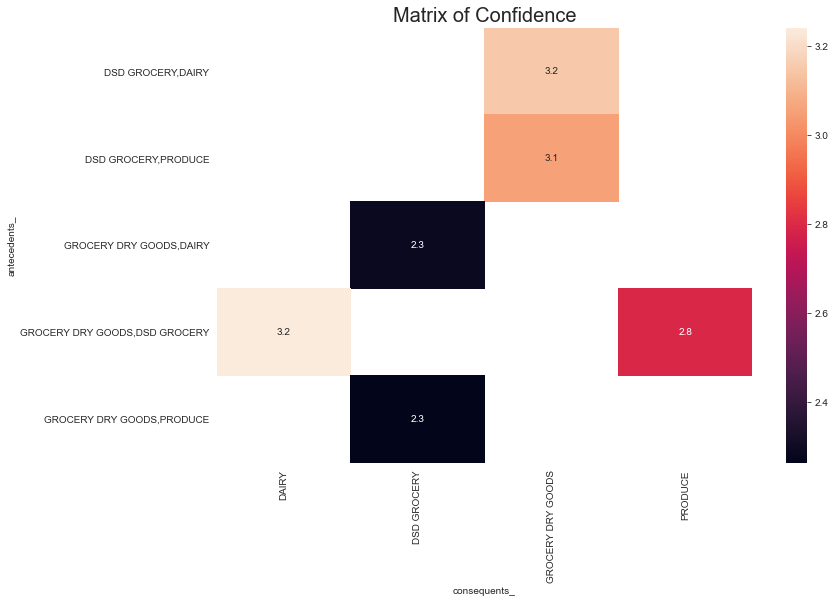

In [76]:
rules_conf['lhs items'] = rules_conf['antecedents'].apply(lambda x:len(x) )
rules_conf[rules_conf['lhs items']>3].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules_conf['antecedents_'] = rules_conf['antecedents'].apply(lambda a: ','.join(list(a)))
rules_conf['consequents_'] = rules_conf['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules_conf[rules_conf['lhs items']>1.0].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules_conf['antecedents_'] = rules_conf['antecedents'].apply(lambda a: ','.join(list(a)))
rules_conf['consequents_'] = rules_conf['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the confidence metric
pivot = rules_conf[rules_conf['lhs items']>1.5].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('Matrix of Confidence',fontsize = 20)
plt.show();

### Network diagram of rules
Here we made network diagram of specified number of rules where we can see the antecedents and consequents connected to the rules

In [77]:
#plotting output in a graph plot.
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
   
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])

        for a in rules.iloc[i]['antecedents']:

            G1.add_nodes_from([a])

            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

        for c in rules.iloc[i]['consequents']:

                G1.add_nodes_from([c])

                G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('orange')
        else:
            color_map.append('green')       
 
   
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            

    for p in pos:  # raise text positions
           pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.title(f'Graph showing {rules_to_show} rules', fontsize=20)
    plt.show()

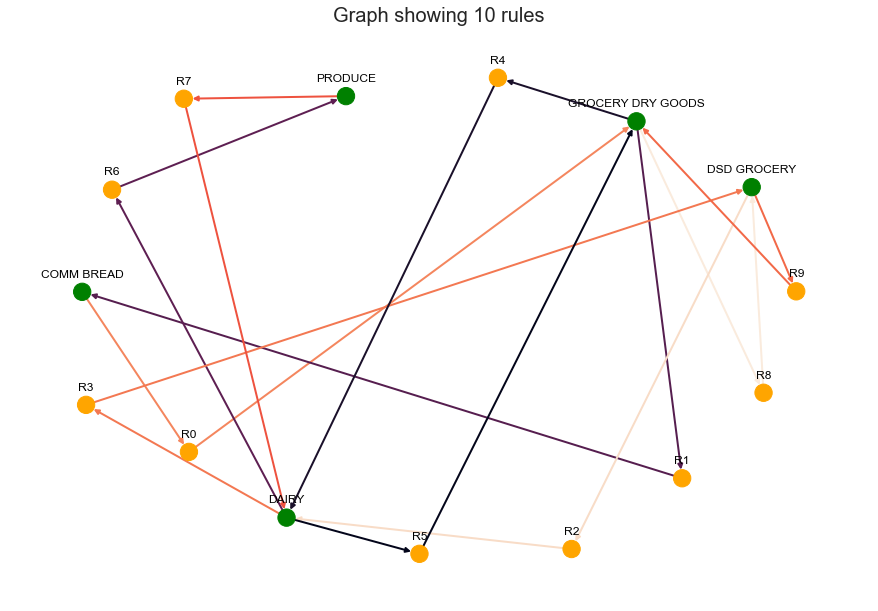

In [78]:
draw_graph(rules_conf, 10)

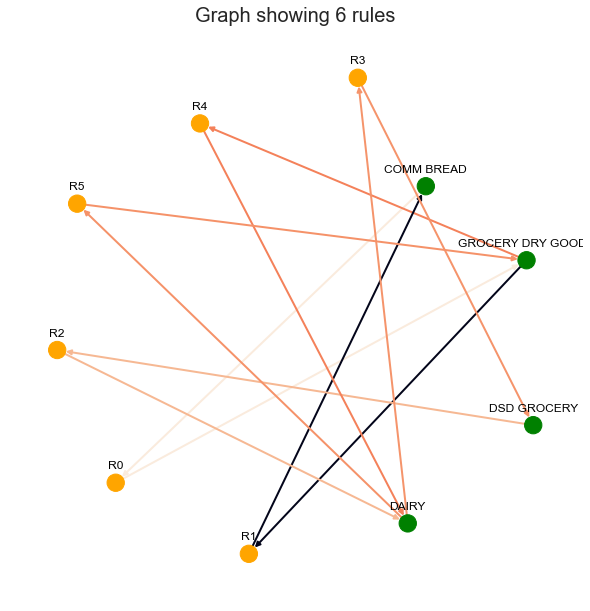

In [79]:
plt.rcParams['figure.figsize'] = (8,8)
draw_graph(rules_conf, 6)

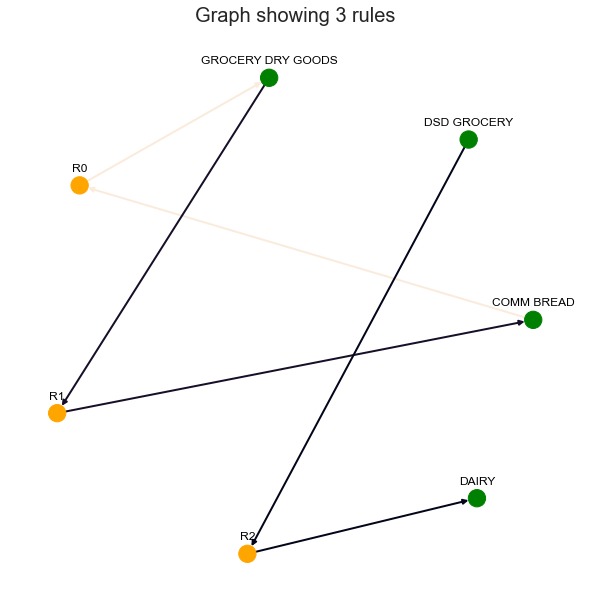

In [80]:
draw_graph(rules_conf, 3)

_The arrow coming to the rules(orange circle) is from anticedents and the arrows going from rules circle are towards conequents(green)._

## Insigths
In conclusion DSD GROCERY and DAIRY/GROCECRY DRY GOODS are the best sellers of Walmart store and had association with other 5 items each.
There are a couple of strategies that the Walmart can adopt (if it isn't using them yet) to increase its sales considering the association we have seen between DSD GROCERY and its 5 partners/ and DAIRY/GROCECRY DRY GOODS and the partners department category.

Promotional discount in either one of the 5 partners can attract customers to buy DSD GROCERY (or the other way round, will also work).
Placing thes items close to DSD GROCERY ordering counter can be a good strategy to attract customers in buying these.


# Apriori algorithm using Apyori

In [81]:
#Set transactions
visit_id = temp.groupby('VisitNumber')
transactions = []
for name,group in visit_id:
    transactions.append(list(group['DepartmentDescription'].map(str)))

In [84]:
# Training Apriori on the dataset
from apyori import apriori
rules_df = apriori(transactions, min_support = 0.005, min_confidence = 0.2, min_lift = 3, min_length = 2)
# Get the results
results = list(rules_df)

In [85]:
# Visualising the result as a readeable dataframe
final_results = pd.DataFrame(np.random.randint(low=0, high=1, size=(len(results), 6)),
                             columns=['GeneralRules', 'LeftRules', 'RightRules', 'Support', 'Confidence', 'Lift'])
index = 0
for g, s, i in results:
    final_results.iloc[index] = [' _&_ '.join(list(g)), ' _&_ '.join(list(i[0][0])), ' _&_ '.join(list(i[0][1])),
                                 s, i[0][2], i[0][3]]
    index = index+1
# The most significant rules
final_results = final_results.sort_values('Lift', ascending=0)
final_results.head(10)

GeneralRules  \
2030  GROCERY DRY GOODS _&_ HOUSEHOLD PAPER GOODS _&...   
1848  HOUSEHOLD PAPER GOODS _&_ COMM BREAD _&_ HOUSE...   
2041  GROCERY DRY GOODS _&_ COMM BREAD _&_ MEAT - FR...   
2042  GROCERY DRY GOODS _&_ COMM BREAD _&_ MEAT - FR...   
2028  COMM BREAD _&_ MEAT - FRESH & FROZEN _&_ DAIRY...   
1918  GROCERY DRY GOODS _&_ COMM BREAD _&_ MEAT - FR...   
1874  GROCERY DRY GOODS _&_ HOUSEHOLD PAPER GOODS _&...   
1902  GROCERY DRY GOODS _&_ HOUSEHOLD PAPER GOODS _&...   
1900  COMM BREAD _&_ MEAT - FRESH & FROZEN _&_ FROZE...   
1872  COMM BREAD _&_ MEAT - FRESH & FROZEN _&_ DAIRY...   

                                         LeftRules  \
2030  HOUSEHOLD CHEMICALS/SUPP _&_ PRE PACKED DELI   
1848  HOUSEHOLD CHEMICALS/SUPP _&_ PRE PACKED DELI   
2041          COMM BREAD _&_ MEAT - FRESH & FROZEN   
2042          COMM BREAD _&_ MEAT - FRESH & FROZEN   
2028          COMM BREAD _&_ MEAT - FRESH & FROZEN   
1918          COMM BREAD _&_ MEAT - FRESH & FROZEN   
1874          COMM BREAD _&_ HOUSEHOLD PAPER GOODS   
1902          COMM BREAD _&_ HOUSEHOLD PAPER GOODS   
1900          COMM BREAD _&_ MEAT - FRESH & FROZEN   
1872          COMM BREAD _&_ MEAT - FRESH & FROZEN   

                                             RightRules   Support  Confidence  \
2030  GROCERY DRY GOODS _&_ HOUSEHOLD PAPER GOODS _&...  0.005142    0.260180   
1848  COMM BREAD _&_ HOUSEHOLD PAPER GOODS _&_ DSD G...  0.005446    0.275516   
2041  GROCERY DRY GOODS _&_ DAIRY _&_ FROZEN FOODS _...  0.005561    0.215647   
2042  GROCERY DRY GOODS _&_ FROZEN FOODS _&_ PRODUCE...  0.005257    0.203891   
2028  DAIRY _&_ FROZEN FOODS _&_ PRODUCE _&_ DSD GRO...  0.005237    0.203081   
1918  PRE PACKED DELI _&_ GROCERY DRY GOODS _&_ FROZ...  0.005864    0.227402   
1874  PRE PACKED DELI _&_ GROCERY DRY GOODS _&_ DAIR...  0.005550    0.202594   
1902  PRE PACKED DELI _&_ GROCERY DRY GOODS _&_ DSD ...  0.005540    0.202213   
1900  PRE PACKED DELI _&_ DSD GROCERY _&_ FROZEN FOO...  0.005487    0.212809   
1872  PRE PACKED DELI _&_ DAIRY _&_ FROZEN FOODS _&_...  0.005801    0.224970   

           Lift  
2030  16.269570  
1848  15.718354  
2041  15.571145  
2042  15.420634  
2028  15.238855  
1918  14.952873  
1874  14.818822  
1902  14.757068  
1900  14.553464  
1872  14.523442

In [86]:
count=1
for i, d in final_results.head(10).iterrows():
    print('Rule '+str(count)+':')
    print(d['LeftRules'])
    print('=> '+d['RightRules'])
    print('Support: '+str(d['Support'])+' - Confidence: '+str(d['Confidence'])+' - Lift: '+str(d['Lift']))
    print('***'*20)
    count=count+1

Rule 1:
HOUSEHOLD CHEMICALS/SUPP _&_ PRE PACKED DELI
=> GROCERY DRY GOODS _&_ HOUSEHOLD PAPER GOODS _&_ COMM BREAD _&_ DAIRY _&_ DSD GROCERY
Support: 0.005142462947091164 - Confidence: 0.26017979904812266 - Lift: 16.269569996163458
************************************************************
Rule 2:
HOUSEHOLD CHEMICALS/SUPP _&_ PRE PACKED DELI
=> COMM BREAD _&_ HOUSEHOLD PAPER GOODS _&_ DSD GROCERY _&_ DAIRY
Support: 0.005445575600476618 - Confidence: 0.27551560021152827 - Lift: 15.718353926438732
************************************************************
Rule 3:
COMM BREAD _&_ MEAT - FRESH & FROZEN
=> GROCERY DRY GOODS _&_ DAIRY _&_ FROZEN FOODS _&_ PRODUCE _&_ PRE PACKED DELI
Support: 0.00556054936555386 - Confidence: 0.2156465342521281 - Lift: 15.57114454191555
************************************************************
Rule 4:
COMM BREAD _&_ MEAT - FRESH & FROZEN
=> GROCERY DRY GOODS _&_ FROZEN FOODS _&_ PRODUCE _&_ DSD GROCERY _&_ PRE PACKED DELI
Support: 0.005257436712168405 -